In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [75]:
data = pd.read_csv("eleicoes_2006_a_2010.csv")

matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff0f8d9c88>,
      dtype=object)

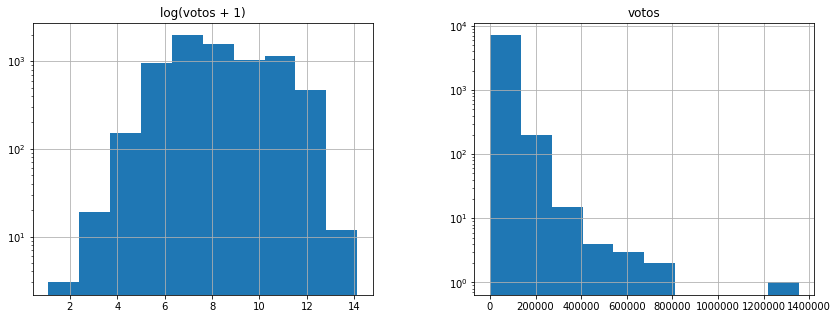

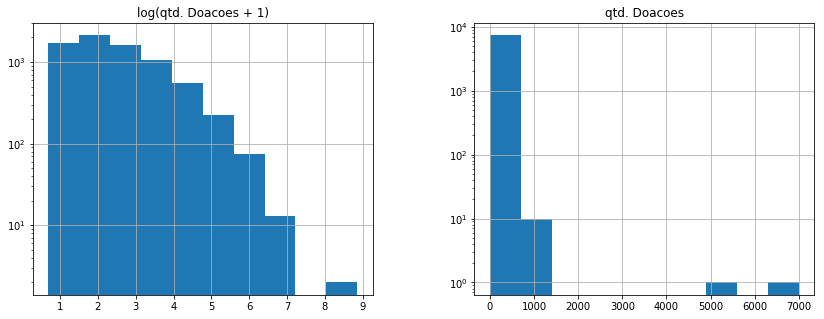

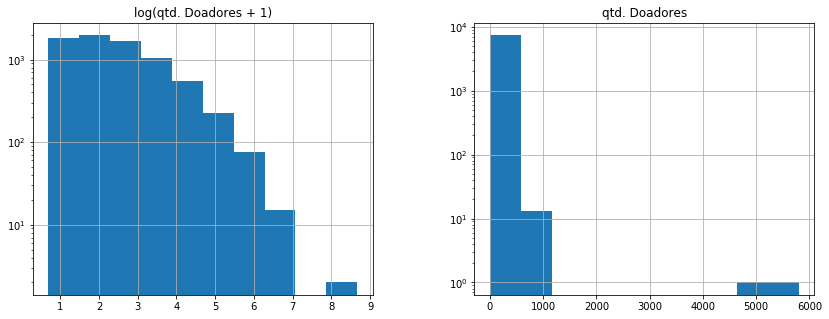

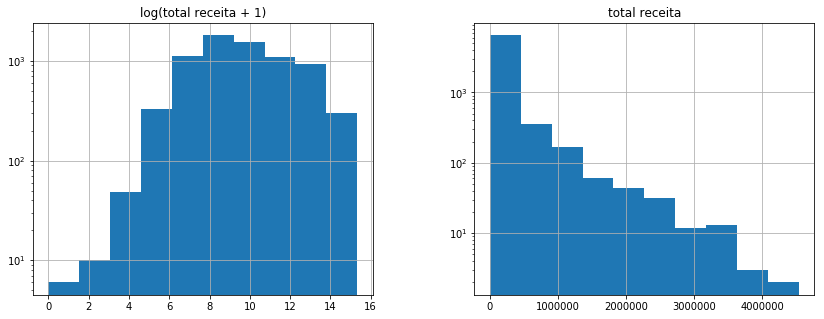

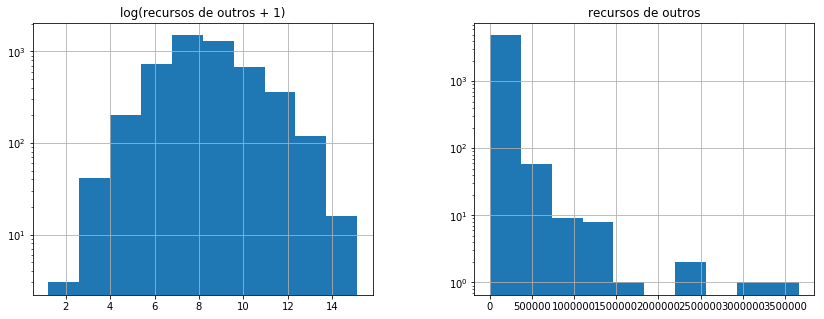

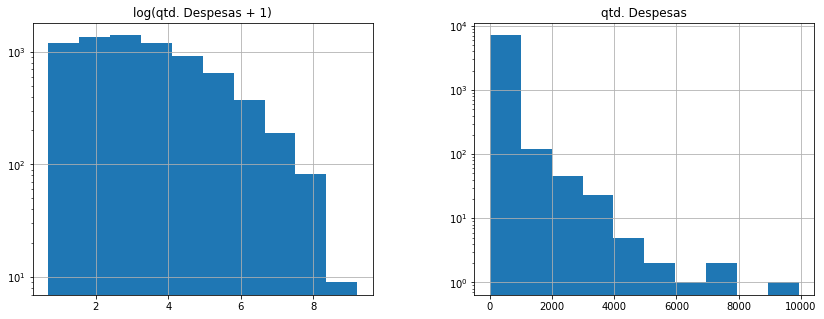

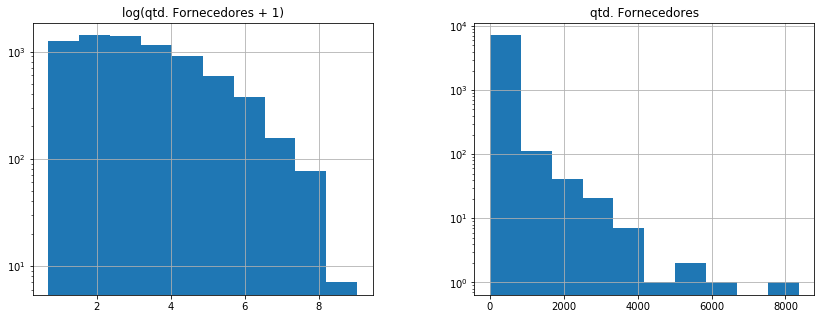

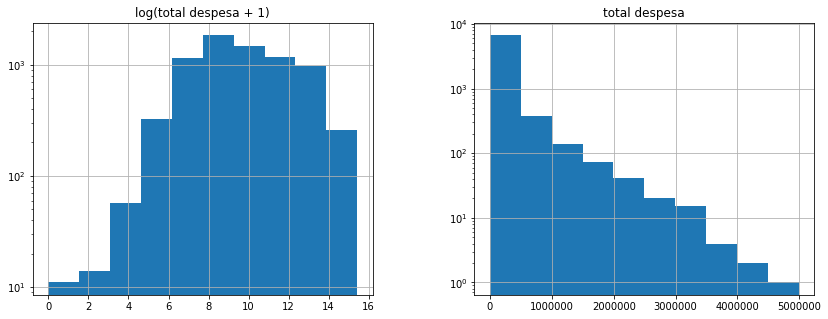

In [46]:
df_votos = pd.DataFrame({"votos":data["votos"], "log(votos + 1)":np.log1p(data["votos"])})
df_votos.hist(log=True)

df_qtdDoacoes = pd.DataFrame({"qtd. Doacoes":data["quantidade_doacoes"], "log(qtd. Doacoes + 1)":np.log1p(data["quantidade_doacoes"])})
df_qtdDoacoes.hist(log=True)

df_qtdDoadores = pd.DataFrame({"qtd. Doadores":data["quantidade_doadores"], "log(qtd. Doadores + 1)":np.log1p(data["quantidade_doadores"])})
df_qtdDoadores.hist(log=True)

df_totalReceita = pd.DataFrame({"total receita":data["total_receita"], "log(total receita + 1)":np.log1p(data["total_receita"])})
df_totalReceita.hist(log=True)

df_recursosOutros = pd.DataFrame({"recursos de outros":data["recursos_de_outros_candidatos/comites"], "log(recursos de outros + 1)":np.log1p(data["recursos_de_outros_candidatos/comites"])})
df_recursosOutros.hist(log=True)

df_qtdDespesas = pd.DataFrame({"qtd. Despesas":data["quantidade_despesas"], "log(qtd. Despesas + 1)":np.log1p(data["quantidade_despesas"])})
df_qtdDespesas.hist(log=True)

df_qtdFornecedores = pd.DataFrame({"qtd. Fornecedores":data["quantidade_fornecedores"], "log(qtd. Fornecedores + 1)":np.log1p(data["quantidade_fornecedores"])})
df_qtdFornecedores.hist(log=True)

df_totalDespesas = pd.DataFrame({"total despesa":data["total_despesa"], "log(total despesa + 1)":np.log1p(data["total_despesa"])})
df_totalDespesas.hist(log=True)

In [76]:
var_alvo = data.loc[:,'votos'] #Variável alvo original (será usada para calcular o rmse na escala real de cada modelo)

data = data.drop(columns=['media_receita','media_despesa','nome'])

Removendo as colunas "media_receita" e "media_despesa", pois elas são derivadas da divisão de "total_receita" por "quantidade_doadores" e "total_despesa" por "quantidade_fornecedores", respectivamente.

In [77]:
#log transform skewed numeric features
numeric_feats = data.dtypes[data.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano') #não aplico normalização na variável ano pois ela é ordinal

data[numeric_feats] = np.log1p(data[numeric_feats])

data = data.drop(columns=['sequencial_candidato'])

/home/renato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


Aplicando normalização em todas as variáveis numéricas, exceto ano, pois apesar de ela ser um número, a considerei ordinal em vez de numérica.

In [78]:
from sklearn.model_selection import train_test_split
entradas = data.loc[:,:'ocupacao']
saida = data.loc[:,'votos']

entradas = entradas.fillna(entradas.mean())
entradas = pd.get_dummies(entradas)

X_train, X_test, Y_train, Y_test = train_test_split(entradas,saida, test_size=0.2, random_state = 15)

dividindo os dados em dados de treino e teste aleatoriamente, com proporção de 75% para treino e 25% para validação.

Aplicando a função dummy nas variáveis categóricas e preenchendo os registros vazios com a mediana da coluna.

## Regressões lineares
### Não regularizada

In [79]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

reg_linear = LinearRegression()
reg_linear.fit(X_train, Y_train)

print(rmse_cv(reg_linear).mean())

502117675.41736346


## Regressão ridge

In [14]:
alphas_ridge = np.arange(0.1,30,0.5).tolist()
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]
cv_ridge = pd.Series(cv_ridge, index = alphas_ridge)

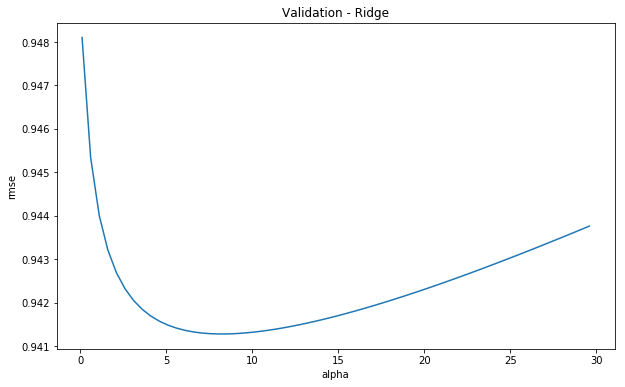

O melhor alpha é 8.1, com rmse = 0.9412769920425589


In [15]:
cv_ridge.plot(title = "Validation - Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

print("O melhor alpha é {0}, com rmse = {1}".format(cv_ridge.idxmin(), cv_ridge.min()))

## Regressão lasso

In [16]:
alphas_lasso = np.arange(0.0001,0.003,0.0001).tolist()

cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=10000)).mean()
            for alpha in alphas_lasso]

cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)

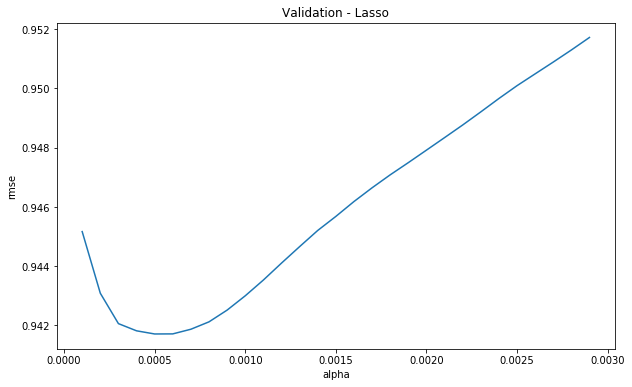

O melhor alpha é 0.0005, com rmse = 0.9417123715776043


In [17]:
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

print("O melhor alpha é {0}, com rmse = {1}".format(cv_lasso.idxmin(), cv_lasso.min()))

## KNN

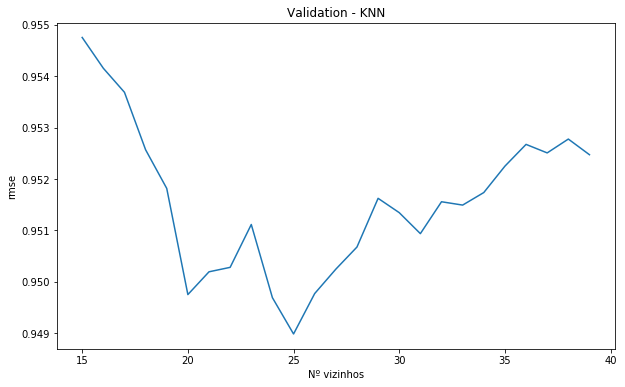

In [18]:
from sklearn.neighbors import KNeighborsRegressor

k_list = np.arange(15,40,1).tolist()

cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors = n)).mean()
            for n in k_list]

cv_knn = pd.Series(cv_knn, index = k_list)
cv_knn.plot(title = "Validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("rmse")
plt.show()

In [19]:
print("O melhor alpha é {0}, com rmse = {1}".format(cv_knn.idxmin(), cv_knn.min()))

O melhor alpha é 25, com rmse = 0.9489825762325186


## Random Forest

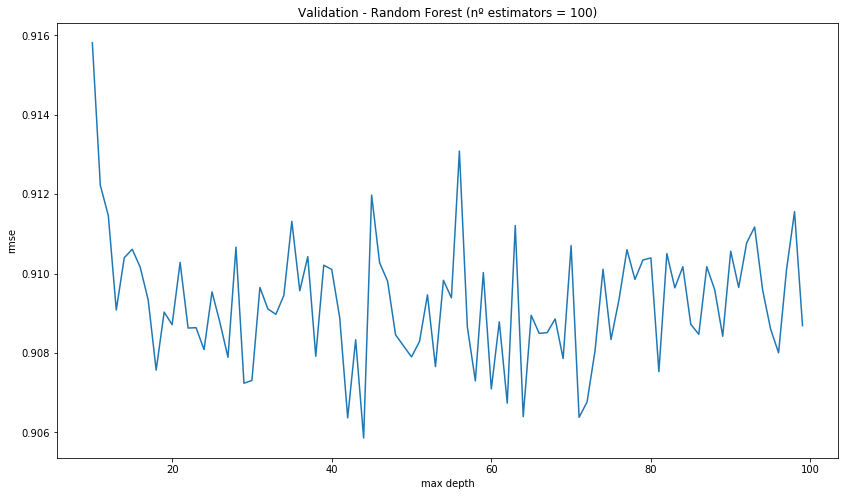

In [15]:
from sklearn.ensemble import RandomForestRegressor

depth_list = np.arange(10,100,1).tolist()

cv_forest = [rmse_cv(RandomForestRegressor(max_depth = max_depth, n_estimators=100)).mean()
            for max_depth in depth_list]

cv_forest = pd.Series(cv_forest, index = depth_list)
cv_forest.plot(title = "Validation - Random Forest (nº estimators = 100)")
plt.xlabel("max depth")
plt.ylabel("rmse")
plt.show()

In [21]:
print("A melhor profundidade (para estimators=100) é {0}, com rmse = {1}".format(cv_forest.idxmin(), cv_forest.min()))

A melhor profundidade (para estimators=100) é 44, com rmse = 0.9058587020511603


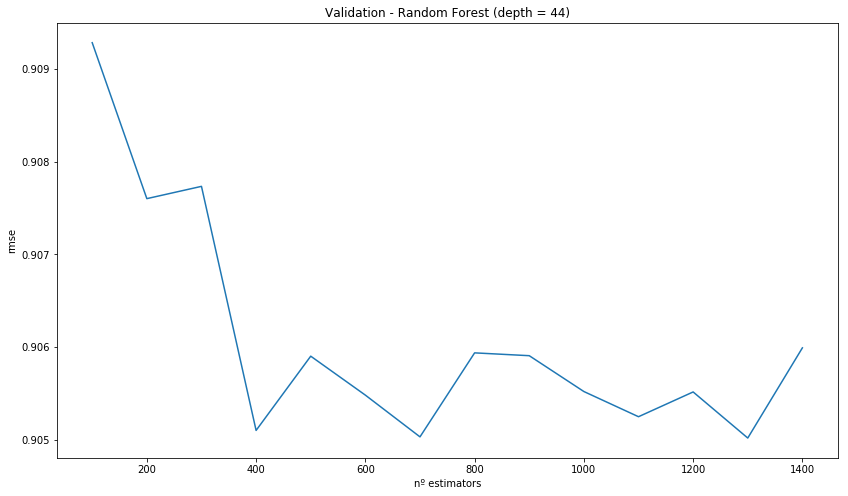

In [17]:
from sklearn.ensemble import RandomForestRegressor

estimators_list = np.arange(100,1500,100).tolist()

cv_forest_dpMin = [rmse_cv(RandomForestRegressor(max_depth = cv_forest.idxmin(), n_estimators = n_estimators)).mean()
            for n_estimators in estimators_list]

cv_forest_dpMin = pd.Series(cv_forest_dpMin, index = estimators_list)
cv_forest_dpMin.plot(title = "Validation - Random Forest (depth = {0})".format(cv_forest.idxmin()))
plt.xlabel("nº estimators")
plt.ylabel("rmse")
plt.show()

In [22]:
print("O melhor número de estimators (para profundidade=44) é {0}, com rmse = {1}".format(cv_forest_dpMin.idxmin(), cv_forest_dpMin.min()))

O melhor número de estimators (para profundidade=44) é 1300, com rmse = 0.9050169882042493


# Predições X Erros

## Ridge

In [113]:
Alvo_test = np.expm1(Y_test)

Aplicando função para retornar os dados de teste para escala original, para calcular o rmse e mostrar a disperção na escala original.

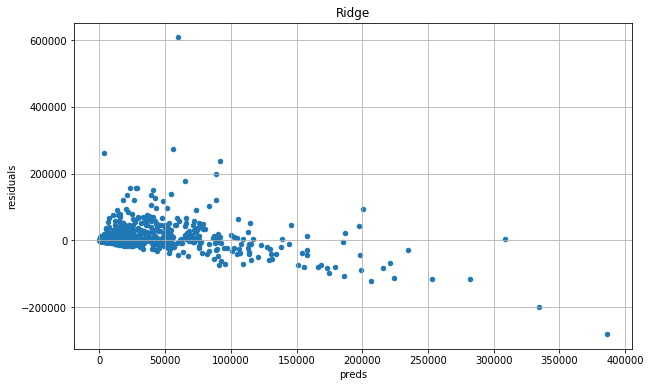

In [114]:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

model_ridge = Ridge(alpha = 8.1)
model_ridge.fit(X_train,Y_train)

preds_ridge = pd.DataFrame({"preds":np.expm1(model_ridge.predict(X_test)), "true":Alvo_test})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
x = preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter", title = "Ridge", grid = True)


In [115]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(preds_ridge["true"],preds_ridge["preds"]))
print("O rmse na validação do modelo Ridge é {0}".format(rmse))

O rmse na validação do modelo Ridge é 32681.2551279803


## Lasso

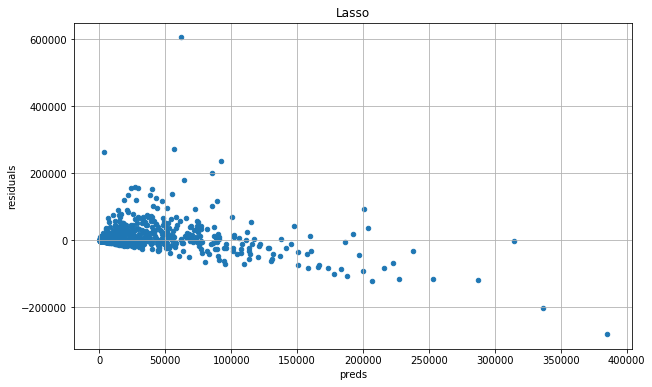

In [105]:
model_lasso = Lasso(alpha = 0.0005)
model_lasso.fit(X_train,Y_train)

preds_lasso = pd.DataFrame({"preds":np.expm1(model_lasso.predict(X_test)), "true":Alvo_test})
preds_lasso["residuals"] = preds_lasso["true"] - preds_lasso["preds"]
preds_lasso.plot(x = "preds", y = "residuals",kind = "scatter", title = "Lasso", grid = True)

In [106]:
rmse = np.sqrt(mean_squared_error(preds_lasso["true"],preds_lasso["preds"]))
print("O rmse na validação do modelo Lasso é {0}".format(rmse))

O rmse na validação do modelo Lasso é 32701.477739934096


## KNN

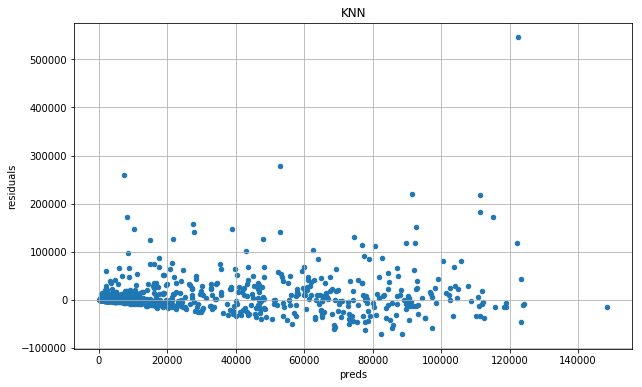

In [107]:
model_knn = KNeighborsRegressor(n_neighbors=25)
model_knn.fit(X_train,Y_train)

preds_knn = pd.DataFrame({"preds":np.expm1(model_knn.predict(X_test)), "true":Alvo_test})
preds_knn["residuals"] = preds_knn["true"] - preds_knn["preds"]
preds_knn.plot(x = "preds", y = "residuals",kind = "scatter", title = "KNN", grid = True)

In [109]:
rmse = np.sqrt(mean_squared_error(preds_knn["true"],preds_knn["preds"]))
print("O rmse na validação do modelo KNN é {0}".format(rmse))

O rmse na validação do modelo KNN é 30112.815418204755


## Random Forest

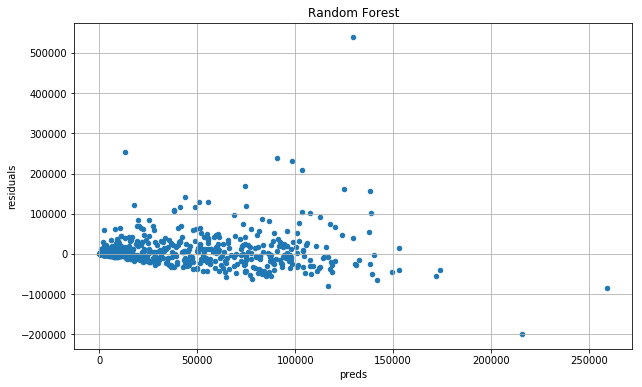

In [111]:
from sklearn.ensemble import RandomForestRegressor

model_forest = RandomForestRegressor(max_depth = 44, n_estimators = 1300)
model_forest.fit(X_train,Y_train)

preds_forest = pd.DataFrame({"preds":np.expm1(model_forest.predict(X_test)), "true":Alvo_test})
preds_forest["residuals"] = preds_forest["true"] - preds_forest["preds"]
preds_forest.plot(x = "preds", y = "residuals",kind = "scatter", title = "Random Forest", grid = True)

In [112]:
rmse = np.sqrt(mean_squared_error(preds_forest["true"],preds_forest["preds"]))
print("O rmse na validação do modelo Random Forest é {0}".format(rmse))

O rmse na validação do modelo Random Forest é 28580.64381825466


# Testando os modelos com dados de 2014

In [119]:
teste = pd.read_csv("eleicoes_2014.csv")

teste = teste.drop(columns=['media_receita','media_despesa','nome', 'sequencial_candidato'])

#log transform skewed numeric features
numeric_feats = teste.dtypes[teste.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano') #não aplico normalização na variável ano pois ela é ordinal

teste[numeric_feats] = np.log1p(data[numeric_feats])

/home/renato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log1p
  # Remove the CWD from sys.path while we load stuff.


In [120]:
teste_entradas = teste.loc[:,:'ocupacao']
teste_alvo = teste.loc[:,'votos']

teste_entradas = teste_entradas.fillna(teste_entradas.mean())
teste_entradas = pd.get_dummies(teste_entradas)

In [121]:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

model_ridge = Ridge(alpha = 8.1)
model_ridge.fit(X_train,Y_train)

preds_ridge = pd.DataFrame({"preds":np.expm1(model_ridge.predict(teste_entradas)), "true":teste_alvo})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
x = preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter", title = "Ridge", grid = True)

ValueError: shapes (4936,244) and (259,) not aligned: 244 (dim 1) != 259 (dim 0)

## Ridge